Pull in the data for the water flow 

In [53]:
import pandas as pd
import csv
import requests
import os
from bs4 import BeautifulSoup
import re

In [54]:
# change to the path with the raw csv file
path=r'C:\Springboard\Github\River_Analysis'
os.chdir(path)

### Enter your USGS gage number below (it must be in quotes)

In [55]:
GAGE = '09066325'

### ^ Enter your USGS gage number above ^

In [56]:
# function for pulling the date range for reach USGS gage
# takes in string of the gage number with USGS
def pull_start(USGS):
    link = "https://waterdata.usgs.gov/nwis/dv?referred_module=sw&site_no=" + USGS
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "html.parser")
    site_sum = soup.find_all(id='available_parameters_table')
    rows_sum = site_sum[0].find_all('tr')
    for row in rows_sum:
        cell_sum = row.find_all('td')
        for i, cell in enumerate(cell_sum):
            if 'discharge' in cell.get_text().lower():
                # get start date from the next cell
                start_date = re.findall(r'\d{4}-\d{2}-\d{2}', cell_sum[i+1].get_text())[0]
                end_date = re.findall(r'\d{4}-\d{2}-\d{2}', cell_sum[i+2].get_text())[0]
                # re.findall(r'\d{4}-\d{2}-\d{2}', cell[next].get_text())[0]
                return start_date, end_date
    return 0, 0

In [57]:
# this function pulls the water date from a given gage from start_date to end_date
raw_file = GAGE + '.csv'
def pull_water(USGS, start_date, end_date):
    link_begin = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no='
    link_mid = '&referred_module=sw&period=&begin_date='
    link_end = '&end_date='
    link = link_begin + USGS + link_mid + start_date + link_end + end_date
    response = requests.get(link)
    # raw_file = USGS + '.csv'
    with open(raw_file, 'wb') as f:
        for chunk in response:
            f.write(chunk)

# this gets a raw file of the data

In [58]:
# pulls the data for just one gage
start_date, end_date = pull_start(GAGE)
pull_water(GAGE, start_date, end_date)


In [59]:
# See 06_data_extraction from gauge_info

# read the raw CSV back in and remove the commented lines
# open raw CSV
fi = open(raw_file, 'r')

# read raw CSV to clean CSV - eliminate comment rows with "#"
clean_file = 'clean.csv'
with open(clean_file, 'w') as fo:
    lines = fi.readlines()
    for line in lines:
        if "#" not in line:
            fo.write(line)
fi.close()

In [60]:
# load daily water flow into a DF
flow = pd.read_csv(clean_file, error_bad_lines=False, delimiter='\t')
flow

,agency_cd,site_no,datetime,18601_00060_00003,18601_00060_00003_cd
0,5s,15s,20d,14n,10s
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
...,...,...,...,...,...
8066,USGS,09066325,2021-10-30,17.4,P
8067,USGS,09066325,2021-10-31,17.5,P
8068,USGS,09066325,2021-11-01,19.2,P
8069,USGS,09066325,2021-11-02,21.2,P


That looks pretty good. I would like to include more of the summer, but that can happen later. Let's drop some of the useless columns and rows.

In [61]:
# drop the first row - that looks like useless data
flow.drop(0, inplace=True)
flow

,agency_cd,site_no,datetime,18601_00060_00003,18601_00060_00003_cd
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
5,USGS,09066325,1999-10-05,29.0,A:e
...,...,...,...,...,...
8066,USGS,09066325,2021-10-30,17.4,P
8067,USGS,09066325,2021-10-31,17.5,P
8068,USGS,09066325,2021-11-01,19.2,P
8069,USGS,09066325,2021-11-02,21.2,P


In [62]:
# rename columns to make for easier dropping
flow.columns = ['agency', 'gage', 'date', 'y', 'useless']
flow

,agency,gage,date,y,useless
1,USGS,09066325,1999-10-01,34.0,A:e
2,USGS,09066325,1999-10-02,33.0,A:e
3,USGS,09066325,1999-10-03,31.0,A:e
4,USGS,09066325,1999-10-04,29.0,A:e
5,USGS,09066325,1999-10-05,29.0,A:e
...,...,...,...,...,...
8066,USGS,09066325,2021-10-30,17.4,P
8067,USGS,09066325,2021-10-31,17.5,P
8068,USGS,09066325,2021-11-01,19.2,P
8069,USGS,09066325,2021-11-02,21.2,P


In [63]:
flow.drop(['agency', 'gage', 'useless'], axis=1, inplace=True)
flow

,date,y
1,1999-10-01,34.0
2,1999-10-02,33.0
3,1999-10-03,31.0
4,1999-10-04,29.0
5,1999-10-05,29.0
...,...,...
8066,2021-10-30,17.4
8067,2021-10-31,17.5
8068,2021-11-01,19.2
8069,2021-11-02,21.2


In [64]:
flow['y'] = flow['y'].astype(float)

In [65]:
# let's check for NaN values
flow['y'].isna().value_counts()

False    8070
Name: y, dtype: int64

In [66]:
# instead of assuming it's all filled, let's fill it
# let's check for NaN values
flow['y'].fillna(method='backfill', inplace=True)

that looks all filled to me. Time to rename the date column and run FB prophet

In [67]:
flow.rename(columns={'date':'ds'}, inplace=True)

Next steps: how do I get the min / max / median / mean from each independent calendar day? <br>
<br>
Perhaps group by month and day

In [68]:
# add day and month columns to the existing DF
flow["Month"] = flow['ds'].str[5:7]
flow["Day"] = flow['ds'].str[8:10]
flow['MD'] = flow["Month"] + '-' + flow["Day"]

In [69]:
flow.dtypes

ds        object
y        float64
Month     object
Day       object
MD        object
dtype: object

In [70]:
flow['Month'] = flow['Month'].astype(int)
flow['Day'] = flow['Day'].astype(int)

In [71]:
summary = flow.groupby(["MD"], as_index=False)['y'].agg(['mean', 'min', 'median', 'max'])
summary

,mean,min,median,max
MD,,,,
01-01,18.404545,12.6,18.10,24.1
01-02,18.018182,10.8,17.60,24.0
01-03,18.190909,11.2,17.95,25.7
01-04,18.418182,10.0,17.75,29.0
01-05,18.090909,11.3,17.80,24.3
...,...,...,...,...
12-27,18.377273,11.0,18.35,23.2
12-28,18.590909,11.5,18.35,24.4
12-29,18.600000,10.1,18.90,23.8


In [72]:
# let's check these values
summary.describe()

,mean,min,median,max
count,366.000000,366.000000,366.000000,366.000000
mean,110.583295,32.071694,96.534153,270.280601
std,173.108132,43.272541,158.353249,423.581849
min,16.581818,8.620000,16.100000,20.800000
25%,18.586023,11.800000,18.750000,25.900000
50%,29.347134,13.200000,25.400000,63.700000
75%,88.373864,24.450000,74.662500,220.750000
max,739.136364,226.000000,792.000000,1730.000000


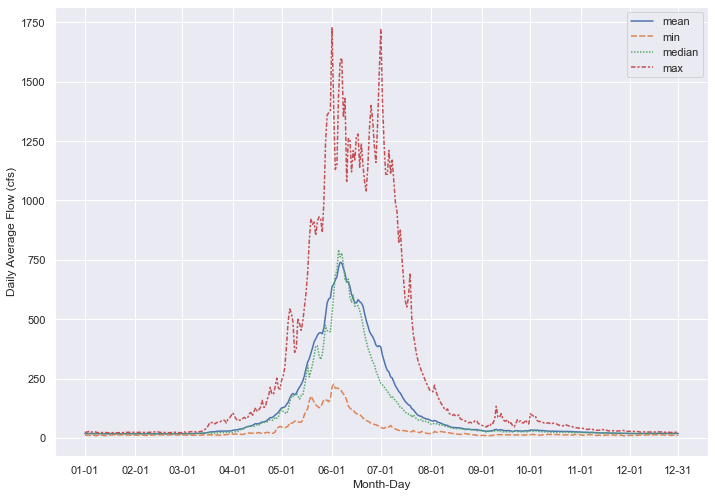

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
# set the figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# create the plot
g  = sns.lineplot(data=summary) # , x='MD', y=['min', 'mean', 'max', 'median'])
_ = plt.xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])
plt.xlabel('Month-Day')
plt.ylabel('Daily Average Flow (cfs)')
plt.savefig('River_Flow.png',bbox_inches='tight')
# g.set_xticks(25)

# g.set_xticklabels(['0','a','b','c','d','e'])
# need to resize
# need to space the markers out more
# need to save this plot so we can add it to a HTML site